In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import csv
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import statistics
from wordcloud import WordCloud, STOPWORDS
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import LabelPowerset
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import BinaryRelevance
from collections import defaultdict
import pickle

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
# open and view CMU books dataset
CMU = pd.read_csv("booksummaries.csv")
CMU.head()

,Wikipedia ID,Freebase ID,Book title,Book author,Publication date,Genres,Plot summary
0,620,/m/0hhy,Animal Farm,George Orwell,17/08/1945,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"": ""Satire"", ""/m/0dwly"": ""Children's literature"", ""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf"": ""Fiction""}","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""Novella"", ""/m/014dfn"": ""Speculative fiction"", ""/m/0c082"": ""Utopian and dystopian fiction"", ""/m/06nbt"": ""Satire"", ""/m/02xlf"": ""Fiction""}","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fiction"", ""/m/0pym5"": ""Absurdist fiction"", ""/m/05hgj"": ""Novel""}","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,"The argument of the Enquiry proceeds by a series of incremental steps, separated into chapters which logically succeed one another. After expounding his epistemology, Hume explains how to apply his principles to specific topics. In the first section of the Enquiry, Hume provides a rough introdu..."
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""Speculative fiction"", ""/m/01hmnh"": ""Fantasy"", ""/m/02xlf"": ""Fiction""}","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."


In [3]:
CMU.shape

(16566, 7)

In [4]:
# remove unneeded columns
CMU=CMU.drop(['Wikipedia ID', 'Freebase ID', 'Publication date'], axis=1)
CMU=CMU.rename(columns={"Book title": "title", "Book author": "author", "Genres":"genres", "Plot summary":"summary"})

In [5]:
# remove books with missing values
CMU=CMU.dropna()

In [6]:
# extract genres from JSON format into lists 
CMU['genres'] = CMU['genres'].map(lambda x: list(json.loads(x).values()))

In [7]:
# re-order columns
columns_titles = ['title','author', 'genres', 'summary']
CMU=CMU.reindex(columns=columns_titles)

In [8]:
# save new dataframe as csv
# CMU.to_csv(r'/Users/yanngo/Dropbox/Uni work/Independent Research Project/new_cmu.csv', index = False)
CMU

,title,author,genres,summary
0,Animal Farm,George Orwell,"[Roman à clef, Satire, Children's literature, Speculative fiction, Fiction]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"[Science Fiction, Novella, Speculative fiction, Utopian and dystopian fiction, Satire, Fiction]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,The Plague,Albert Camus,"[Existentialism, Fiction, Absurdist fiction, Novel]","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
4,A Fire Upon the Deep,Vernor Vinge,"[Hard science fiction, Science Fiction, Speculative fiction, Fantasy, Fiction]","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
5,All Quiet on the Western Front,Erich Maria Remarque,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
...,...,...,...,...
16556,The Third Lynx,Timothy Zahn,[Science Fiction],"The story starts with former government agent, Frank Compton, meeting a young man who drops dead at his feet. Compton finds a ticket to a strange, interstellar train called the Quadrail. During Compton's ride on the Quadrail he falls asleep, and wakes up in the custody of the spiders, the opera..."
16558,Remote Control,Andy McNab,"[Thriller, Fiction, Suspense]","The series follows the character of Nick Stone, an ex-military man who previously worked for the SAS, British Intelligence, and an American agency. Stone now works as a paid mercenary, willing to work in even the most difficult circumstances. The series has Stone dealing with assassination, pol..."
16562,Transfer of Power,Vince Flynn,"[Thriller, Fiction]","The reader first meets Rapp while he is doing a covert operation in Iran and he discovers a possible terrorist attack planned for the nations capital to happen in the near future. Meanwhile in Washington, D.C., Anna Reilly is starting her first day as a White House correspondent for NBC. It als..."
16563,Decoded,Jay-Z,[Autobiography],"The book follows very rough chronological order, while switching from current stories to his story of growing up in the Marcy projects. The autobiographical portion focuses on not only his story of drug dealing, fights, and the beginnings in rap, but also his reflections on those times in his l..."


In [9]:
# function to show frequency of genres
def show_genres_frequency_chart(genres_series):
    list_genres = sum(genres_series,[])

    list_genres = nltk.FreqDist(list_genres) 

    # create dataframe
    list_genres_df = pd.DataFrame({'Genre': list(list_genres.keys()), 
                                  'Count': list(list_genres.values())})

    graph = list_genres_df.nlargest(columns="Count", n = 50) 
    plt.figure(figsize=(12,15)) 
    axis = sns.barplot(data=graph, x= "Count", y = "Genre") 
    axis.set(ylabel = 'Genre') 
    plt.show()
    
    return list_genres_df

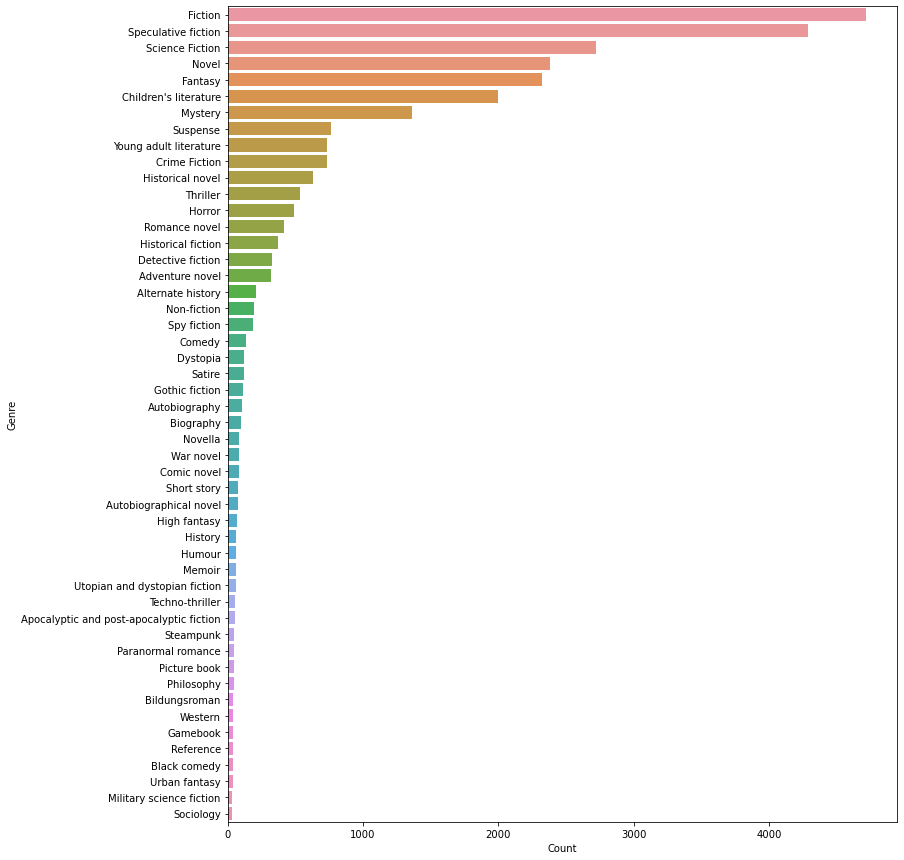

In [10]:
cmu_genres_count_df = show_genres_frequency_chart(CMU.genres)

In [11]:
# map genres to list of genres that it should become if the genre is not present then it is removed
genres_conversion = {
    'alien invasion': ['science fiction'],
    'satire': ['comedy'],
    'war novel': ['war'],
    'romance novel': ['romance'],
    'science fiction': ['science fiction'],
    "children's literature": ["children's literature"],
    'speculative fiction': ['speculative fiction'],
    'utopian and dystopian fiction':['utopian and dystopian'],
    'hard science fiction':['science fiction'],
    'fantasy': ['fantasy'],
    'horror':['horror'],
    'parody': ['comedy'], 
    'mystery':['mystery'], 
    'dystopia':['utopian and dystopian'],
    'detective fiction':['crime'],
    'suspense':['suspense'],
    'historical fiction':['historical'],
    'adventure novel':['adventure'],
    'humour':['comedy'], 
    'historical novel':['historical'],
    'cyberpunk':['science fiction'], 
    'chivalric romance':['romance'], 
    'high fantasy':['fantasy'],
    'time travel':['fantasy'],
    'scientific romance':['romance', 'science fiction'],
    'crime fiction':['crime'], 
    'juvenile fantasy':['young adult literature', 'fantasy'],
    'techno-thriller':['science fiction', 'thriller'], 
    'thriller':['thriller'],
    'young adult literature':['young adult literature'],
    'comedy':['comedy'],
    'vampire fiction':['horror'], 
    'zombies in popular culture':['horror'],
    'apocalyptic and post-apocalyptic fiction':['apocalyptic and post-apocalyptic fiction'],
    'alternate history':['fantasy'],
    'spy fiction':['spy fiction'],
    'autobiographical novel':['autobiography and biography'],
    'memoir':['autobiography and biography'],
    'autobiography':['autobiography and biography'],
    'postcyberpunk':['science fiction'],
    'anti-war':['war'],
    'hardboiled':['crime'],
    'western':['western'],
    'comic science fiction':['science fiction', 'comedy'],
    'lost world':['science fiction'],
    'biography':['autobiography and biography'],
    'western fiction':['western'],
    'comic novel':['comedy'],
    'conspiracy fiction':['thriller'],
    'planetary romance':['science fiction'],
    'military science fiction':['science fiction', 'war'],
    'ghost story':['horror'],
    'fairy tale':["children's literature"],
    'adventure':['adventure'],
    'comic fantasy':['comedy', 'fantasy'],
    'travel':['travel'],
    'magic realism':['fantasy'],
    'locked room mystery':['crime'],
    'feminist science fiction':['science fiction'], 
    'historical whodunnit':['mystery', 'historical'],
    'soft science fiction':['science fiction'],
    'steampunk':['science fiction'],
    'new weird':['speculative fiction'],
    'tragicomedy':['comedy'],
    'biographical novel':['autobiography and biography'],
    'whodunit':['crime'],
    'naval adventure':['adventure'],
    'social science fiction':['science fiction'],
    'travel literature':['travel'],
    'dark fantasy':['fantasy'],
    'fantasy of manners':['fantasy'],
    'science fantasy':['science fiction', 'fantasy'], 
    'utopian fiction':['utopian and dystopian'],
    'zombie':['horror'],
    'historical romance':['historical', 'romance'], 
    'future history':['science fiction', 'speculative fiction'],
    'urban fantasy':['fantasy'],
    'romantic comedy':['romance', 'comedy'],
    'regency romance':['romance'],
    'elizabethan romance':['romance'],
    'georgian romance':['romance'],
    'american gothic fiction':['horror'],
    'space western':['science fiction', 'western'],
    'historical fantasy':['historical', 'fantasy'],
    'sword and sorcery':['fantasy'],
    'medieval romance':['romance'],
    'paranormal romance':['romance', 'horror'],
    'contemporary fantasy':['fantasy'],
    'superhero fiction':['fantasy'],
    'heroic fantasy':['fantasy'],
    'colonial united states romance':['romance'],
    'low fantasy':['fantasy'],
    'fairytale fantasy':["children's literature", 'fantasy'],
    'biopunk':['science fiction'],
    'epic science fiction and fantasy':['science fiction', 'fantasy'],
    'juvenile fiction':['young adult literature'],
    'fiction - romance':['romance'],
    'children: young adult (gr. 7-9)':["children's literature"],
    'children’s books':["children's literature"],
    'children: grades 4-6':["children's literature"],
    'ages 9-12 fiction':["children's literature"],
    'children: young adult (gr. 10-12)':["children's literature"],
    'children’s books - young adult fiction':["children's literature"],
    'children’s 12-up - fiction - general':["children's literature"],
    'horror & ghost stories':['horror'],
    'horror stories':['horror'],
    'horror & ghost stories, chillers':['horror'],
    'romance - general':['romance'],
    'romance: modern':['romance'],
    'romance - contemporary':['romance'],
    'romance - historical':['romance'],
    'love':['romance'],
    'science fiction, fantasy, & magic':['science fiction', 'fantasy'],
    'magic':['fantasy'],
    'fiction - fantasy':['fantasy'],
    'fantasy.':['fantasy'],
    'fantasy fiction':['fantasy'],
    'action & adventure - general':['adventure'],


}

def transform_genres(genres):
    
    # lowercase all genres
    lowercase_genres = [genre.lower() for genre in genres]
    
    # convert genres
    converted_genres = []
    for genre in lowercase_genres:
        if genre in genres_conversion:
            # add the converted genres
            converted_genres.extend(genres_conversion[genre])
    
    # remove duplicate genres from list
    deduplicated_genres = list(set(converted_genres))
    
    return deduplicated_genres

In [12]:
CMU['genres'] = CMU['genres'].apply(transform_genres)
CMU

,title,author,genres,summary
0,Animal Farm,George Orwell,"[children's literature, speculative fiction, comedy]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction, utopian and dystopian, comedy]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,The Plague,Albert Camus,[],"The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."
4,A Fire Upon the Deep,Vernor Vinge,"[science fiction, speculative fiction, fantasy]","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
5,All Quiet on the Western Front,Erich Maria Remarque,[war],"The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
...,...,...,...,...
16556,The Third Lynx,Timothy Zahn,[science fiction],"The story starts with former government agent, Frank Compton, meeting a young man who drops dead at his feet. Compton finds a ticket to a strange, interstellar train called the Quadrail. During Compton's ride on the Quadrail he falls asleep, and wakes up in the custody of the spiders, the opera..."
16558,Remote Control,Andy McNab,"[thriller, suspense]","The series follows the character of Nick Stone, an ex-military man who previously worked for the SAS, British Intelligence, and an American agency. Stone now works as a paid mercenary, willing to work in even the most difficult circumstances. The series has Stone dealing with assassination, pol..."
16562,Transfer of Power,Vince Flynn,[thriller],"The reader first meets Rapp while he is doing a covert operation in Iran and he discovers a possible terrorist attack planned for the nations capital to happen in the near future. Meanwhile in Washington, D.C., Anna Reilly is starting her first day as a White House correspondent for NBC. It als..."
16563,Decoded,Jay-Z,[autobiography and biography],"The book follows very rough chronological order, while switching from current stories to his story of growing up in the Marcy projects. The autobiographical portion focuses on not only his story of drug dealing, fights, and the beginnings in rap, but also his reflections on those times in his l..."


In [13]:
# removing books with no genres
CMU = CMU[CMU['genres'].map(lambda d: len(d)) > 0]
CMU

,title,author,genres,summary
0,Animal Farm,George Orwell,"[children's literature, speculative fiction, comedy]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction, utopian and dystopian, comedy]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
4,A Fire Upon the Deep,Vernor Vinge,"[science fiction, speculative fiction, fantasy]","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
5,All Quiet on the Western Front,Erich Maria Remarque,[war],"The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
6,A Wizard of Earthsea,Ursula K. Le Guin,"[children's literature, fantasy, speculative fiction]","Ged is a young boy on Gont, one of the larger islands in the north of the archipelago of Earthsea. His mother is dead, his much older siblings have all left home, and his father is a dour, taciturn bronzesmith with nothing in common with his son, so the boy grows up wild and headstrong. Ged dis..."
...,...,...,...,...
16556,The Third Lynx,Timothy Zahn,[science fiction],"The story starts with former government agent, Frank Compton, meeting a young man who drops dead at his feet. Compton finds a ticket to a strange, interstellar train called the Quadrail. During Compton's ride on the Quadrail he falls asleep, and wakes up in the custody of the spiders, the opera..."
16558,Remote Control,Andy McNab,"[thriller, suspense]","The series follows the character of Nick Stone, an ex-military man who previously worked for the SAS, British Intelligence, and an American agency. Stone now works as a paid mercenary, willing to work in even the most difficult circumstances. The series has Stone dealing with assassination, pol..."
16562,Transfer of Power,Vince Flynn,[thriller],"The reader first meets Rapp while he is doing a covert operation in Iran and he discovers a possible terrorist attack planned for the nations capital to happen in the near future. Meanwhile in Washington, D.C., Anna Reilly is starting her first day as a White House correspondent for NBC. It als..."
16563,Decoded,Jay-Z,[autobiography and biography],"The book follows very rough chronological order, while switching from current stories to his story of growing up in the Marcy projects. The autobiographical portion focuses on not only his story of drug dealing, fights, and the beginnings in rap, but also his reflections on those times in his l..."


In [14]:
CMU.shape

(9891, 4)

In [15]:
# open and view OL and GB dataset 
OLGB = pd.read_csv("books.csv")
OLGB.head()

,gb_query,gb_title,gb_authors,gb_description,gb_categories,olb_subjects_isbn13,olb_subjects_isbn10
0,subject:science fiction,"Your Day, Your Way",Timothy Caulfield,"Part pop-science, part self-help, Your Day. Your Way. is a friendly, funny, fact-based guide to changing how you make decisions in order to live a better -- maybe even your best -- life. We make, and worry about, a thousand big and little decisions during our waking hours. And for most of us, th...",Science,NaN,NaN
1,subject:science fiction,Appraisal,NaN,NaN,Science,NaN,NaN
2,subject:science fiction,Science Fiction,Terence Kealey,NaN,Great Britain,Science -- Great Britain.,Science -- Great Britain.
3,subject:science fiction,Archangel: Fiction,Andrea Barrett,"A 12-year-old boy discovers the wonders of science and the natural world from motorized bicycles, to airplanes, to x-ray technology and genetics in this collection of five stories by the National Book Award-winning author of Ship Fever. 30,000 first printing.",Fiction,Science|Fiction|History,Science|Fiction|History
4,subject:science fiction,Science Reporter,NaN,NaN,Science,NaN,NaN


In [16]:
OLGB.shape

(2384, 7)

In [17]:
# remove books with no description
OLGB.dropna(subset = ["gb_description"], inplace=True)

In [18]:
# change all NaN values to 'UNKNOWN'
OLGB= OLGB.fillna('UNKNOWN')

In [19]:
# combine categories, queries and subjects to make a genres column
OLGB['genres']=OLGB['gb_categories'].astype(str)+'|'+OLGB['olb_subjects_isbn13']+'|'+OLGB['olb_subjects_isbn10']

In [20]:
# remove unneeded columns
OLGB=OLGB.drop(['gb_query', 'gb_categories', 'olb_subjects_isbn13', 'olb_subjects_isbn10'], axis=1)
OLGB=OLGB.rename(columns={"gb_title": "title", "gb_authors": "author", "gb_description":"summary"})

In [21]:
# rename and re-order columns
columns_titles = ['title','author', 'genres', 'summary']
OLGB=OLGB.reindex(columns=columns_titles)

In [22]:
# removing / from genres
OLGB['genres'] = OLGB['genres'].map(lambda x: x.replace("/", "|"))

In [23]:
# clean genres
OLGB["genres"] = OLGB["genres"].str.lower()
OLGB['genres'] = OLGB['genres'].map(lambda x: list(x.split("|")))

In [24]:
OLGB

,title,author,genres,summary
0,"Your Day, Your Way",Timothy Caulfield,"[science, unknown, unknown]","Part pop-science, part self-help, Your Day. Your Way. is a friendly, funny, fact-based guide to changing how you make decisions in order to live a better -- maybe even your best -- life. We make, and worry about, a thousand big and little decisions during our waking hours. And for most of us, th..."
3,Archangel: Fiction,Andrea Barrett,"[fiction, science, fiction, history, science, fiction, history]","A 12-year-old boy discovers the wonders of science and the natural world from motorized bicycles, to airplanes, to x-ray technology and genetics in this collection of five stories by the National Book Award-winning author of Ship Fever. 30,000 first printing."
7,"Alien Life ,From Science Fiction to Science Fact",Joseph Angelo,"[astronomy, unknown, unknown]","Designed to help students and teachers better appreciate science and engineering in a global context, this eBook gives a brief history of humanity's fascination with space going back to prehistory and shows how space travel bec."
9,Practising Science Communication in the Information Age,Richard Holliman|Jeff Thomas|Sam Smidt|Eileen Scanlon|Elizabeth Whitelegg,"[language arts & disciplines, unknown, unknown]","Practising science communication in the information age reviews the trends and issues that are engaging practitioners of science communication, critically exploring topics as diverse as peer review, open access publication, the protection of intellectual property, the popularisation of science, ..."
11,The Screenwriter's Handbook 2009,B. Turner,"[juvenile nonfiction, unknown, unknown]","""This is the essential guide for all aspiring, new and established writers for the screen. It includes hundreds of useful contact detail entries from courses, societies and grants to representation and production companies.""--Provided by publisher."
...,...,...,...,...
2379,The Giants and the Joneses,Julia Donaldson,"[juvenile fiction, unknown, unknown]","When Jumbeelia, an eight-year-old giant, climbs down a beanstalk and collects some ""iggly plops,"" the little people of children's stories, she treats them like toys, unaware that she is endangering their lives."
2380,Girl on a Wire,Gwenda Bond,"[juvenile fiction, teenage girls, juvenile fiction, circus, girls, teenagers, fiction, fantasy, aerialists, mystery fiction, teenage girls, juvenile fiction, circus, girls, teenagers, fiction, fantasy, aerialists, mystery fiction]","Sixteen-year-old Jules Maroni's dream of becoming a high-wire walker like her father comes true when her family accepts a prestigious circus position, but in the face of a rival acrobat family established there, Jules finds help from a surprising ally."
2381,The Riverman,Aaron Starmer,"[juvenile fiction, fantasy, juvenile fiction , social themes , friendship, juvenile fiction, friendship, juvenile fiction , fantasy & magic, fiction, fantasy, juvenile fiction , social themes , friendship, juvenile fiction, friendship, juvenile fiction , fantasy & magic, fiction]","""The first book in a trilogy about a girl who claims she is visiting a parallel universe where a nefarious being called The Riverman is stealing the souls of children and the boy she asks to write her biography because she fears her soul may be next""--"
2382,The Lord of Castle Black,Steven Brust,"[fiction, fantasy - general, fiction, fiction - fantasy, fantasy, action & adventure, fantasy - epic, fiction , fantasy , epic, fantasy - general, fiction, fiction - fantasy, fantasy, action & adventure, fantasy - epic, fiction , fantasy , epic]","The Dragonlord Moorlan encounters such challenges as swordplay, quests, romance, and a missing heir to the Imperial Throne."


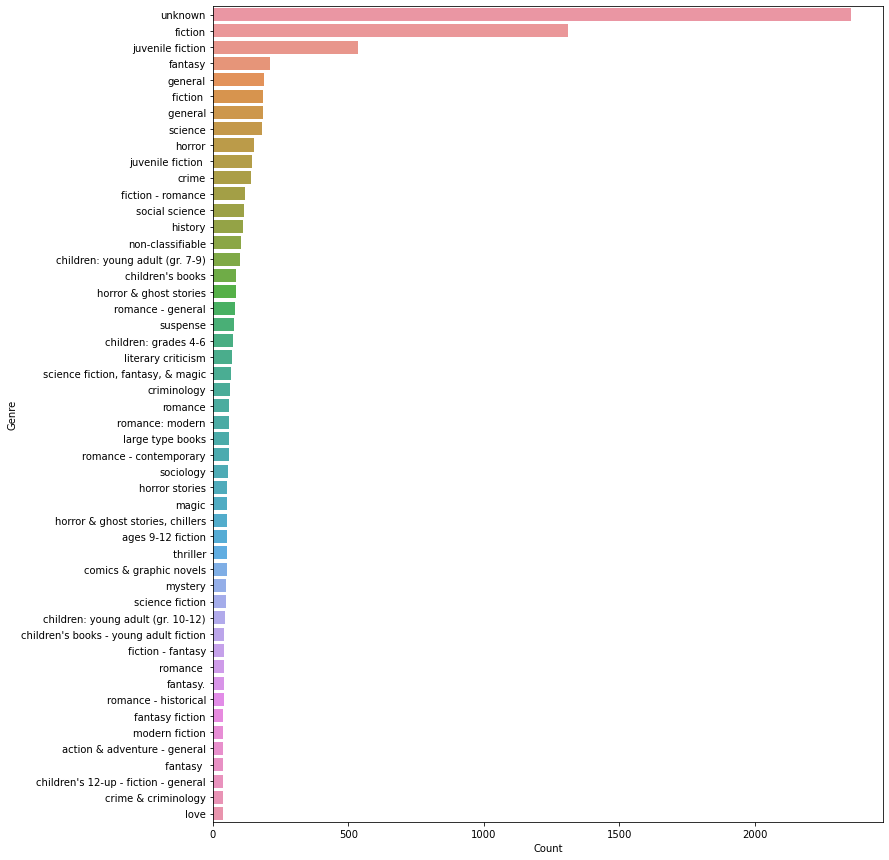

In [25]:
olgb_genres_count_df = show_genres_frequency_chart(OLGB.genres)

In [26]:
# total unique genres
len(olgb_genres_count_df['Genre'].unique())

1925

In [27]:
# removing irrelevant genres
OLGB['genres'] = OLGB['genres'].apply(transform_genres)
OLGB

,title,author,genres,summary
0,"Your Day, Your Way",Timothy Caulfield,[],"Part pop-science, part self-help, Your Day. Your Way. is a friendly, funny, fact-based guide to changing how you make decisions in order to live a better -- maybe even your best -- life. We make, and worry about, a thousand big and little decisions during our waking hours. And for most of us, th..."
3,Archangel: Fiction,Andrea Barrett,[],"A 12-year-old boy discovers the wonders of science and the natural world from motorized bicycles, to airplanes, to x-ray technology and genetics in this collection of five stories by the National Book Award-winning author of Ship Fever. 30,000 first printing."
7,"Alien Life ,From Science Fiction to Science Fact",Joseph Angelo,[],"Designed to help students and teachers better appreciate science and engineering in a global context, this eBook gives a brief history of humanity's fascination with space going back to prehistory and shows how space travel bec."
9,Practising Science Communication in the Information Age,Richard Holliman|Jeff Thomas|Sam Smidt|Eileen Scanlon|Elizabeth Whitelegg,[],"Practising science communication in the information age reviews the trends and issues that are engaging practitioners of science communication, critically exploring topics as diverse as peer review, open access publication, the protection of intellectual property, the popularisation of science, ..."
11,The Screenwriter's Handbook 2009,B. Turner,[],"""This is the essential guide for all aspiring, new and established writers for the screen. It includes hundreds of useful contact detail entries from courses, societies and grants to representation and production companies.""--Provided by publisher."
...,...,...,...,...
2379,The Giants and the Joneses,Julia Donaldson,[young adult literature],"When Jumbeelia, an eight-year-old giant, climbs down a beanstalk and collects some ""iggly plops,"" the little people of children's stories, she treats them like toys, unaware that she is endangering their lives."
2380,Girl on a Wire,Gwenda Bond,"[fantasy, young adult literature]","Sixteen-year-old Jules Maroni's dream of becoming a high-wire walker like her father comes true when her family accepts a prestigious circus position, but in the face of a rival acrobat family established there, Jules finds help from a surprising ally."
2381,The Riverman,Aaron Starmer,"[fantasy, young adult literature]","""The first book in a trilogy about a girl who claims she is visiting a parallel universe where a nefarious being called The Riverman is stealing the souls of children and the boy she asks to write her biography because she fears her soul may be next""--"
2382,The Lord of Castle Black,Steven Brust,[fantasy],"The Dragonlord Moorlan encounters such challenges as swordplay, quests, romance, and a missing heir to the Imperial Throne."


In [28]:
# removing books with no genres
OLGB=OLGB[OLGB['genres'].map(lambda d: len(d)) > 0]

In [29]:
# function to remove duplicate genres
def duplicate_genres(x):
  return list(dict.fromkeys(x))

OLGB['genres'] = OLGB['genres'].apply(duplicate_genres)
OLGB

<ipython-input-29-3ecfa8d47d6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OLGB['genres'] = OLGB['genres'].apply(duplicate_genres)


,title,author,genres,summary
44,Time Machines,Bill Adler,"[science fiction, fantasy]",Time Machines is a mind-bending collection o f time-travel tales from popular and science fiction writers . It is one of the most fluid forms of storytelling and cros ses over between science fiction and literary fiction. '
53,Think Like a Scientist,Melissa Blackwell Burke|burke,[young adult literature],This pairing of fiction and non-fiction literature features a story about a clever girl who wants to create the most surprising science fair project ever. The companion book describes six different fields of science.
55,Inquizitive: Winter,Brenda Parkes,[children's literature],"INQUIZITIVE SCIENCE EMERGENT LEVEL: MAGNETS - A series of information books that integrate literacy and science. INQUIZITIVE with a focus upon science has been developed to help young children gain an understanding of: the different ways information can be read and communicated, the specialised ..."
81,A Fever In The Heart,Ann Rule,[autobiography and biography],A collection of dramatic true crime stories includes the tale of a woman and two men caught up in an explosive love triangle that leads to obsession and murder in a small midwestern town. Original.
115,Where Do We Go From Here?,UNKNOWN,[comedy],Why would a healthy 25-year-old man choose to live and work in a care home for elderly and disabled people? This is the question that dejected Nurse Jen asks when she reluctantly joins the staff of the Easy Love Care Home. She is surprised to find James not only a live-in employee at this Scotti...
...,...,...,...,...
2379,The Giants and the Joneses,Julia Donaldson,[young adult literature],"When Jumbeelia, an eight-year-old giant, climbs down a beanstalk and collects some ""iggly plops,"" the little people of children's stories, she treats them like toys, unaware that she is endangering their lives."
2380,Girl on a Wire,Gwenda Bond,"[fantasy, young adult literature]","Sixteen-year-old Jules Maroni's dream of becoming a high-wire walker like her father comes true when her family accepts a prestigious circus position, but in the face of a rival acrobat family established there, Jules finds help from a surprising ally."
2381,The Riverman,Aaron Starmer,"[fantasy, young adult literature]","""The first book in a trilogy about a girl who claims she is visiting a parallel universe where a nefarious being called The Riverman is stealing the souls of children and the boy she asks to write her biography because she fears her soul may be next""--"
2382,The Lord of Castle Black,Steven Brust,[fantasy],"The Dragonlord Moorlan encounters such challenges as swordplay, quests, romance, and a missing heir to the Imperial Throne."


In [30]:
OLGB.shape

(679, 4)

In [31]:
CMU.shape

(9891, 4)

In [32]:
# concatenate both datasets
frames = [CMU, OLGB]
books = pd.concat(frames)
books

,title,author,genres,summary
0,Animal Farm,George Orwell,"[children's literature, speculative fiction, comedy]","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction, utopian and dystopian, comedy]","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
4,A Fire Upon the Deep,Vernor Vinge,"[science fiction, speculative fiction, fantasy]","The novel posits that space around the Milky Way is divided into concentric layers called Zones, each being constrained by different laws of physics and each allowing for different degrees of biological and technological advancement. The innermost, the ""Unthinking Depths"", surrounds the galacti..."
5,All Quiet on the Western Front,Erich Maria Remarque,[war],"The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they me..."
6,A Wizard of Earthsea,Ursula K. Le Guin,"[children's literature, fantasy, speculative fiction]","Ged is a young boy on Gont, one of the larger islands in the north of the archipelago of Earthsea. His mother is dead, his much older siblings have all left home, and his father is a dour, taciturn bronzesmith with nothing in common with his son, so the boy grows up wild and headstrong. Ged dis..."
...,...,...,...,...
2379,The Giants and the Joneses,Julia Donaldson,[young adult literature],"When Jumbeelia, an eight-year-old giant, climbs down a beanstalk and collects some ""iggly plops,"" the little people of children's stories, she treats them like toys, unaware that she is endangering their lives."
2380,Girl on a Wire,Gwenda Bond,"[fantasy, young adult literature]","Sixteen-year-old Jules Maroni's dream of becoming a high-wire walker like her father comes true when her family accepts a prestigious circus position, but in the face of a rival acrobat family established there, Jules finds help from a surprising ally."
2381,The Riverman,Aaron Starmer,"[fantasy, young adult literature]","""The first book in a trilogy about a girl who claims she is visiting a parallel universe where a nefarious being called The Riverman is stealing the souls of children and the boy she asks to write her biography because she fears her soul may be next""--"
2382,The Lord of Castle Black,Steven Brust,[fantasy],"The Dragonlord Moorlan encounters such challenges as swordplay, quests, romance, and a missing heir to the Imperial Throne."


In [33]:
# save new dataframe as csv
#books.to_csv(r'/Users/yanngo/Dropbox/Uni work/Independent Research Project/cleaned_books.csv', index = False)

In [34]:
# after manually deleting 64 books with irrelevant summaries such as 'to be added later' using excel,
# the csv was saved and reopened 
books = pd.read_csv("cleaned_books.csv")
books

,title,author,genres,summary,genres_count
0,Animal Farm,George Orwell,"['speculative fiction', 'comedy', ""children's literature""]",old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt se...,3
1,A Clockwork Orange,Anthony Burgess,"['science fiction', 'speculative fiction', 'comedy', 'utopian and dystopian']",alex teenager living near future england leads gang nightly orgies opportunistic random ultra violence alexs friends droogs novels anglo russian slang nadsat dim slow witted bruiser gangs muscle georgie ambitious second command pete mostly plays along droogs indulge taste ultra violence characte...,4
2,A Fire Upon the Deep,Vernor Vinge,"['science fiction', 'fantasy', 'speculative fiction']",posits space around milky way divided concentric layers called zones constrained different laws physics allowing different degrees biological technological advancement innermost unthinking depths surrounds galactic core incapable supporting advanced life forms next layer slow zone roughly equiva...,3
3,All Quiet on the Western Front,Erich Maria Remarque,['war'],book tells story paul b umer german soldier urged school teacher joins german army shortly start world war b umer arrives western front friends schoolmates tjaden ller kropp number characters meet stanislaus katczinsky older soldier nicknamed kat becomes pauls mentor fighting front b umer comrad...,1
4,A Wizard of Earthsea,Ursula K. Le Guin,"['fantasy', 'speculative fiction', ""children's literature""]",ged young boy gont larger islands north archipelago earthsea mother dead much older siblings left home father dour taciturn bronzesmith nothing common son boy grows wild headstrong ged discovers accident extraordinary talent magic aunt village witch teaches little knows power far exceeds day use...,3
...,...,...,...,...,...
10485,The Giants and the Joneses,Julia Donaldson,['young adult literature'],jumbeelia eight year old giant climbs beanstalk collects iggly plops little people childrens stories treats like toys unaware endangering lives,1
10486,Girl on a Wire,Gwenda Bond,"['fantasy', 'young adult literature']",sixteen year old jules maronis dream becoming high wire walker like father comes true family accepts prestigious circus position face rival acrobat family established jules help surprising ally,2
10487,The Riverman,Aaron Starmer,"['fantasy', 'young adult literature']",book trilogy girl claims visiting parallel universe nefarious called riverman stealing souls children boy asks write biography fears soul may next,2
10488,The Lord of Castle Black,Steven Brust,['fantasy'],dragonlord moorlan encounters challenges swordplay quests romance missing heir imperial throne,1


In [35]:
# # debugggg
# def filter_rows_with_func(df, filter_func):
#     return df[df.apply(filter_func, axis=1)].copy()


# def book_is_romance(book_row):
#     return 'romance' in book_row['genres']

# romance_books = filter_rows_with_func(books, book_is_romance)
# romance_books

In [36]:
books['genres'] = books.genres.apply(lambda x: literal_eval(str(x)))

In [37]:
# get all genre tags in a list
all_genres = sum(books.genres,[])

# create a dictionary of genres and their occurrences 
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
all_genres_df

,Genre,Count
0,speculative fiction,4266
1,comedy,345
2,children's literature,2113
3,science fiction,2865
4,utopian and dystopian,148
5,fantasy,2725
6,war,118
7,horror,663
8,mystery,1369
9,suspense,782


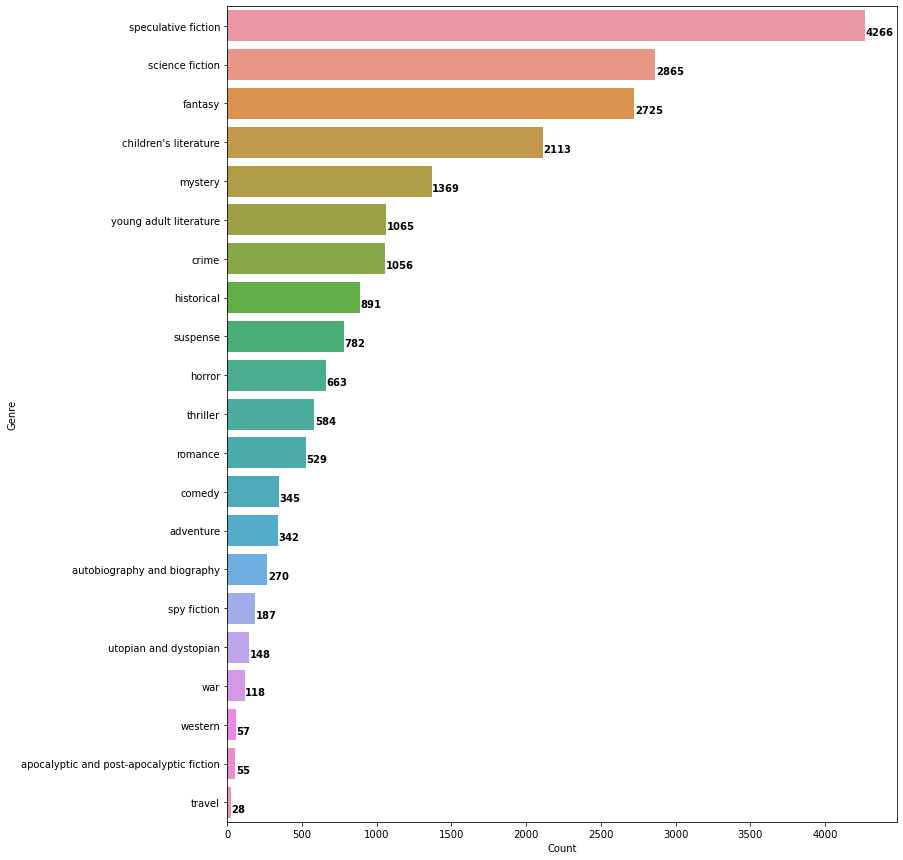

In [38]:
# plot the distribution of the book genres
g = all_genres_df.nlargest(columns="Count", n = 22) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
for i, v in enumerate(g['Count']):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='bold')
    
plt.show()

In [39]:
# make a number of genres column
books['genres_count'] = books['genres'].map(lambda genres_list: len(genres_list))
books

,title,author,genres,summary,genres_count
0,Animal Farm,George Orwell,"[speculative fiction, comedy, children's literature]",old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt se...,3
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction, comedy, utopian and dystopian]",alex teenager living near future england leads gang nightly orgies opportunistic random ultra violence alexs friends droogs novels anglo russian slang nadsat dim slow witted bruiser gangs muscle georgie ambitious second command pete mostly plays along droogs indulge taste ultra violence characte...,4
2,A Fire Upon the Deep,Vernor Vinge,"[science fiction, fantasy, speculative fiction]",posits space around milky way divided concentric layers called zones constrained different laws physics allowing different degrees biological technological advancement innermost unthinking depths surrounds galactic core incapable supporting advanced life forms next layer slow zone roughly equiva...,3
3,All Quiet on the Western Front,Erich Maria Remarque,[war],book tells story paul b umer german soldier urged school teacher joins german army shortly start world war b umer arrives western front friends schoolmates tjaden ller kropp number characters meet stanislaus katczinsky older soldier nicknamed kat becomes pauls mentor fighting front b umer comrad...,1
4,A Wizard of Earthsea,Ursula K. Le Guin,"[fantasy, speculative fiction, children's literature]",ged young boy gont larger islands north archipelago earthsea mother dead much older siblings left home father dour taciturn bronzesmith nothing common son boy grows wild headstrong ged discovers accident extraordinary talent magic aunt village witch teaches little knows power far exceeds day use...,3
...,...,...,...,...,...
10485,The Giants and the Joneses,Julia Donaldson,[young adult literature],jumbeelia eight year old giant climbs beanstalk collects iggly plops little people childrens stories treats like toys unaware endangering lives,1
10486,Girl on a Wire,Gwenda Bond,"[fantasy, young adult literature]",sixteen year old jules maronis dream becoming high wire walker like father comes true family accepts prestigious circus position face rival acrobat family established jules help surprising ally,2
10487,The Riverman,Aaron Starmer,"[fantasy, young adult literature]",book trilogy girl claims visiting parallel universe nefarious called riverman stealing souls children boy asks write biography fears soul may next,2
10488,The Lord of Castle Black,Steven Brust,[fantasy],dragonlord moorlan encounters challenges swordplay quests romance missing heir imperial throne,1


In [40]:
# keep the top 12 genres

# map genres to list of genres that it should become; if the genre is not present then it is removed
genres_conversion2 = {
    'speculative fiction': ['speculative fiction'],
    'science fiction':['science fiction'],
    'fantasy': ['fantasy'],
    "children's literature":["children's literature"],
    'mystery':['mystery'], 
    'young adult literature':['young adult literature'],
    'crime':['crime'],
    'suspense':['suspense'],
    'historical':['historical'],
    'horror':['horror'],
    'thriller':['thriller'],  
    'romance':['romance'],

}

def transform_genres2(genres):
    
    # lowercase all genres
    lowercase_genres = [genre.lower() for genre in genres]
    
    # convert genres
    converted_genres = []
    for genre in lowercase_genres:
        if genre in genres_conversion2:
            # add the converted genres
            converted_genres.extend(genres_conversion2[genre])
    
    # remove duplicate genres from list
    deduplicated_genres = list(set(converted_genres))
    
    return deduplicated_genres

In [41]:
# TESTING 

books['genres'] = books['genres'].apply(transform_genres2)
books

,title,author,genres,summary,genres_count
0,Animal Farm,George Orwell,"[speculative fiction, children's literature]",old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt se...,3
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction]",alex teenager living near future england leads gang nightly orgies opportunistic random ultra violence alexs friends droogs novels anglo russian slang nadsat dim slow witted bruiser gangs muscle georgie ambitious second command pete mostly plays along droogs indulge taste ultra violence characte...,4
2,A Fire Upon the Deep,Vernor Vinge,"[science fiction, speculative fiction, fantasy]",posits space around milky way divided concentric layers called zones constrained different laws physics allowing different degrees biological technological advancement innermost unthinking depths surrounds galactic core incapable supporting advanced life forms next layer slow zone roughly equiva...,3
3,All Quiet on the Western Front,Erich Maria Remarque,[],book tells story paul b umer german soldier urged school teacher joins german army shortly start world war b umer arrives western front friends schoolmates tjaden ller kropp number characters meet stanislaus katczinsky older soldier nicknamed kat becomes pauls mentor fighting front b umer comrad...,1
4,A Wizard of Earthsea,Ursula K. Le Guin,"[speculative fiction, children's literature, fantasy]",ged young boy gont larger islands north archipelago earthsea mother dead much older siblings left home father dour taciturn bronzesmith nothing common son boy grows wild headstrong ged discovers accident extraordinary talent magic aunt village witch teaches little knows power far exceeds day use...,3
...,...,...,...,...,...
10485,The Giants and the Joneses,Julia Donaldson,[young adult literature],jumbeelia eight year old giant climbs beanstalk collects iggly plops little people childrens stories treats like toys unaware endangering lives,1
10486,Girl on a Wire,Gwenda Bond,"[young adult literature, fantasy]",sixteen year old jules maronis dream becoming high wire walker like father comes true family accepts prestigious circus position face rival acrobat family established jules help surprising ally,2
10487,The Riverman,Aaron Starmer,"[young adult literature, fantasy]",book trilogy girl claims visiting parallel universe nefarious called riverman stealing souls children boy asks write biography fears soul may next,2
10488,The Lord of Castle Black,Steven Brust,[fantasy],dragonlord moorlan encounters challenges swordplay quests romance missing heir imperial throne,1


In [42]:
# removing books with no genres
books=books[books['genres'].map(lambda d: len(d)) > 0]
books

,title,author,genres,summary,genres_count
0,Animal Farm,George Orwell,"[speculative fiction, children's literature]",old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt se...,3
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction]",alex teenager living near future england leads gang nightly orgies opportunistic random ultra violence alexs friends droogs novels anglo russian slang nadsat dim slow witted bruiser gangs muscle georgie ambitious second command pete mostly plays along droogs indulge taste ultra violence characte...,4
2,A Fire Upon the Deep,Vernor Vinge,"[science fiction, speculative fiction, fantasy]",posits space around milky way divided concentric layers called zones constrained different laws physics allowing different degrees biological technological advancement innermost unthinking depths surrounds galactic core incapable supporting advanced life forms next layer slow zone roughly equiva...,3
4,A Wizard of Earthsea,Ursula K. Le Guin,"[speculative fiction, children's literature, fantasy]",ged young boy gont larger islands north archipelago earthsea mother dead much older siblings left home father dour taciturn bronzesmith nothing common son boy grows wild headstrong ged discovers accident extraordinary talent magic aunt village witch teaches little knows power far exceeds day use...,3
5,Blade Runner 3: Replicant Night,K. W. Jeter,"[science fiction, speculative fiction]",living mars deckard acting consultant movie crew filming story blade runner days drawn mission behalf replicants assigned kill meanwhile mystery surrounding beginnings tyrell corporation dragged light,2
...,...,...,...,...,...
10485,The Giants and the Joneses,Julia Donaldson,[young adult literature],jumbeelia eight year old giant climbs beanstalk collects iggly plops little people childrens stories treats like toys unaware endangering lives,1
10486,Girl on a Wire,Gwenda Bond,"[young adult literature, fantasy]",sixteen year old jules maronis dream becoming high wire walker like father comes true family accepts prestigious circus position face rival acrobat family established jules help surprising ally,2
10487,The Riverman,Aaron Starmer,"[young adult literature, fantasy]",book trilogy girl claims visiting parallel universe nefarious called riverman stealing souls children boy asks write biography fears soul may next,2
10488,The Lord of Castle Black,Steven Brust,[fantasy],dragonlord moorlan encounters challenges swordplay quests romance missing heir imperial throne,1


In [43]:
# # debug: how many genres are there after removing all rows without genres?

# # get all genre tags in a list
# all_genres2 = sum(books.genres,[])

# # create a dictionary of genres and their occurrences 
# all_genres2 = nltk.FreqDist(all_genres2) 

# # create dataframe
# all_genres_df2 = pd.DataFrame({'Genre': list(all_genres2.keys()), 
#                               'Count': list(all_genres2.values())})
# all_genres_df2

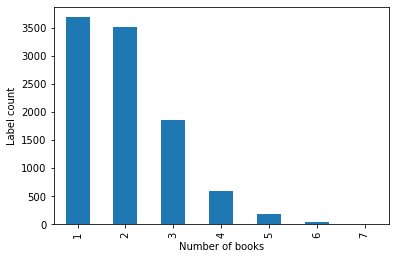

In [44]:
#TODO turn into histogram?
books['genres_count'].value_counts().plot(kind='bar')
plt.ylabel("Label count")
plt.xlabel("Number of books")
for i, v in enumerate(books['genres_count'].value_counts()):
    ax.text(i, v, str(v), color='black', fontweight='bold')

In [45]:
# get the Count Mean, Standard Devaition, Minimum Value, 25th Percentile, 
# 50th Percentile (Median), 75th Percentile, and Maximum Value from the dataset
description = books.describe()
print(description)

       genres_count
count   9867.000000
mean       2.008108
std        1.024203
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        7.000000


In [46]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", str(text)) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [47]:
# apply the function on the book summaries
books['summary'] = books['summary'].apply(lambda x: clean_text(x))
books

<ipython-input-47-ef7c0ea80975>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['summary'] = books['summary'].apply(lambda x: clean_text(x))


,title,author,genres,summary,genres_count
0,Animal Farm,George Orwell,"[speculative fiction, children's literature]",old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt se...,3
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction]",alex teenager living near future england leads gang nightly orgies opportunistic random ultra violence alexs friends droogs novels anglo russian slang nadsat dim slow witted bruiser gangs muscle georgie ambitious second command pete mostly plays along droogs indulge taste ultra violence characte...,4
2,A Fire Upon the Deep,Vernor Vinge,"[science fiction, speculative fiction, fantasy]",posits space around milky way divided concentric layers called zones constrained different laws physics allowing different degrees biological technological advancement innermost unthinking depths surrounds galactic core incapable supporting advanced life forms next layer slow zone roughly equiva...,3
4,A Wizard of Earthsea,Ursula K. Le Guin,"[speculative fiction, children's literature, fantasy]",ged young boy gont larger islands north archipelago earthsea mother dead much older siblings left home father dour taciturn bronzesmith nothing common son boy grows wild headstrong ged discovers accident extraordinary talent magic aunt village witch teaches little knows power far exceeds day use...,3
5,Blade Runner 3: Replicant Night,K. W. Jeter,"[science fiction, speculative fiction]",living mars deckard acting consultant movie crew filming story blade runner days drawn mission behalf replicants assigned kill meanwhile mystery surrounding beginnings tyrell corporation dragged light,2
...,...,...,...,...,...
10485,The Giants and the Joneses,Julia Donaldson,[young adult literature],jumbeelia eight year old giant climbs beanstalk collects iggly plops little people childrens stories treats like toys unaware endangering lives,1
10486,Girl on a Wire,Gwenda Bond,"[young adult literature, fantasy]",sixteen year old jules maronis dream becoming high wire walker like father comes true family accepts prestigious circus position face rival acrobat family established jules help surprising ally,2
10487,The Riverman,Aaron Starmer,"[young adult literature, fantasy]",book trilogy girl claims visiting parallel universe nefarious called riverman stealing souls children boy asks write biography fears soul may next,2
10488,The Lord of Castle Black,Steven Brust,[fantasy],dragonlord moorlan encounters challenges swordplay quests romance missing heir imperial throne,1


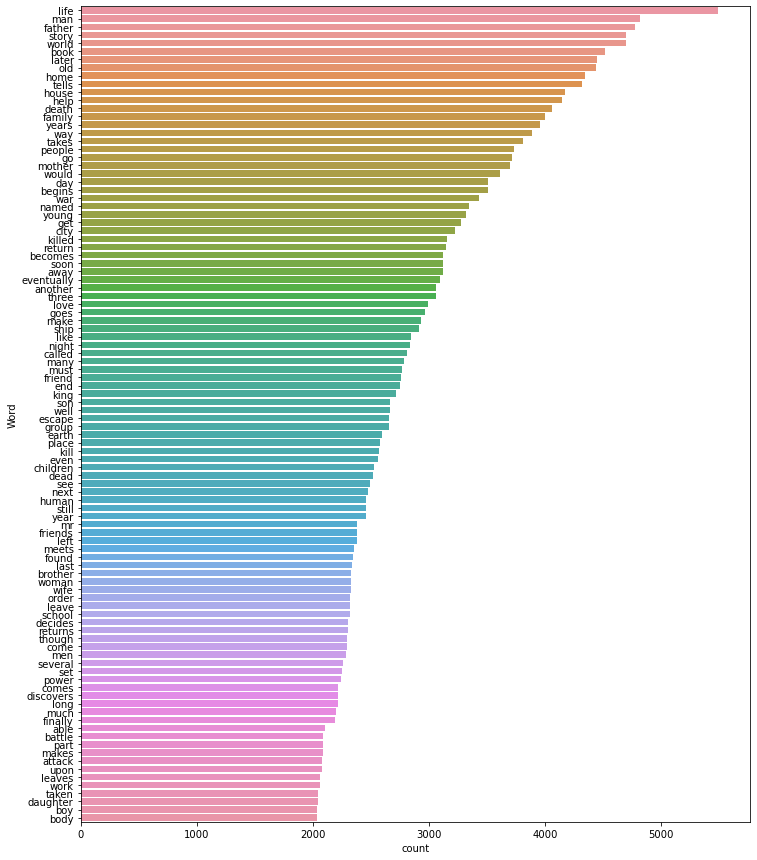

In [48]:
# visualise most frequent words in the summaries column
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(books['summary'], 100)

In [49]:
# remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(('one', 'time', 'also', 'two', 'new', 'back', 'find', 'first', 'however', 'tell', 'become', 'novel', 'take', 'finds'))


# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

books['summary'] = books['summary'].apply(lambda x: remove_stopwords(x))

<ipython-input-49-96d574aa7554>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['summary'] = books['summary'].apply(lambda x: remove_stopwords(x))


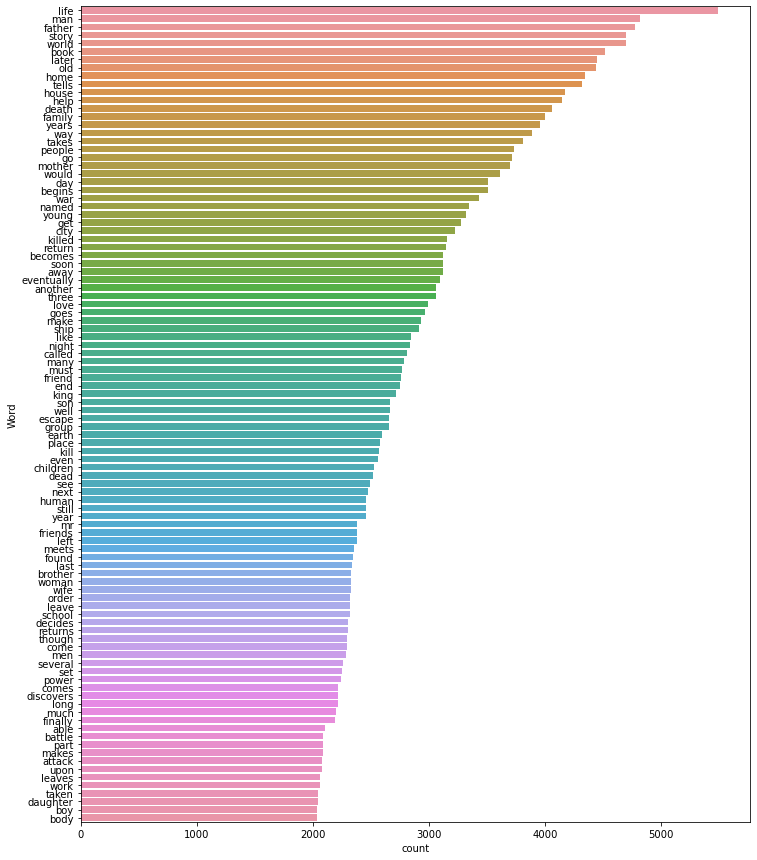

In [50]:
# most frequent words minus stopwords
freq_words(books['summary'], 100)

In [51]:
# Iterating through the summary column 
speculative_fiction_summaries = ''
science_fiction_summaries = ''
fantasy_summaries = ''
childrens_literature_summaries = ''
mystery_summaries = ''

def get_summaries_by_genre(summaries_and_genres_df):
#     summaries_by_genre = {}
#     # every genre starts by mapping to an empty list
#     for genre in genres_of_interest:
#         summaries_by_genre[genre] = []

    # for every row in the DF, append the summary to the relevant genre
    summaries_by_genre = defaultdict(str)
    for i, row in summaries_and_genres_df.iterrows():
        for genre in row.genres:
            summaries_by_genre[genre] += ' ' + row.summary
            
    return summaries_by_genre
    
            
summaries_by_genre = get_summaries_by_genre(books)

In [52]:
# Creating Word Clouds
def show_word_cloud(words):
    final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(words)    
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(final_wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [53]:
# # speculative fiction word cloud 
# show_word_cloud(summaries_by_genre['speculative fiction'])

In [54]:
# # science fiction word cloud 
# show_word_cloud(summaries_by_genre['science fiction'])

In [55]:
# # fantasy word cloud 
# show_word_cloud(summaries_by_genre['fantasy'])

In [56]:
# # children's literature word cloud 
# show_word_cloud(summaries_by_genre["children's literature"])

In [57]:
# # mystery word cloud 
# show_word_cloud(summaries_by_genre['mystery'])

In [58]:
# DELETE?
# generic filtering logic example; square-bracketing the DF with boolean list/series says whether to keep/ignore that row.
# df = pd.DataFrame({'letter':['a','b','c'], 'word':['art','boy','cow']})
# filter_series = pd.Series([True,False,True])
# print('Non-filtered:')
# display(df)
# print('Filtered:')
# display(df[filter_series])

# filter every row of a DF using a filtering function.
# filter_func should be a function that takes a row parameter and returns a boolean; True to keep row, False to not.
def filter_rows_with_func(df, filter_func):
    return df[df.apply(filter_func, axis=1)].copy()

# example filter function that returns True if the book how 4 genres, otherwise returns False.
# def book_has_4_genres(book_row):
#     return book_row['genres_count'] == 4

# This returns all books that have 4 genres and filters out the rest.
# filter_rows_with_func(books, book_has_4_genres)

In [59]:
# # DELETE?
# # get all scifi books
# science_fiction_books = filter_rows_with_func(books, lambda book_row: 'science fiction' in book_row['genres'])

# # select only 1000 scifi books
# science_fiction_books = science_fiction_books.head(1000) # TODO should randomly sample or head?

# science_fiction_books

In [60]:
# double-sample books that are only romance (originally 211 of them)

def book_is_only_romance(book_row):
    return book_row['genres'] == ['romance']

only_romance_books = filter_rows_with_func(books, book_is_only_romance)

books = pd.concat([books, only_romance_books])
books

,title,author,genres,summary,genres_count
0,Animal Farm,George Orwell,"[speculative fiction, children's literature]",old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adopt se...,3
1,A Clockwork Orange,Anthony Burgess,"[science fiction, speculative fiction]",alex teenager living near future england leads gang nightly orgies opportunistic random ultra violence alexs friends droogs novels anglo russian slang nadsat dim slow witted bruiser gangs muscle georgie ambitious second command pete mostly plays along droogs indulge taste ultra violence characte...,4
2,A Fire Upon the Deep,Vernor Vinge,"[science fiction, speculative fiction, fantasy]",posits space around milky way divided concentric layers called zones constrained different laws physics allowing different degrees biological technological advancement innermost unthinking depths surrounds galactic core incapable supporting advanced life forms next layer slow zone roughly equiva...,3
4,A Wizard of Earthsea,Ursula K. Le Guin,"[speculative fiction, children's literature, fantasy]",ged young boy gont larger islands north archipelago earthsea mother dead much older siblings left home father dour taciturn bronzesmith nothing common son boy grows wild headstrong ged discovers accident extraordinary talent magic aunt village witch teaches little knows power far exceeds day use...,3
5,Blade Runner 3: Replicant Night,K. W. Jeter,"[science fiction, speculative fiction]",living mars deckard acting consultant movie crew filming story blade runner days drawn mission behalf replicants assigned kill meanwhile mystery surrounding beginnings tyrell corporation dragged light,2
...,...,...,...,...,...
10456,Promises from the Past,Victoria Bruce,[romance],searching missing father nothing vague memories guide maggie westshire swept past meets handsome shea younger tempts abandon quest original,1
10457,Breathless,Kimberly Raye,[romance],breathless kimberly raye released feb available purchase,1
10460,Dancing in the Dark,Carolyn Ross,[romance],sarah brady enters television dance contest good friend eric elliott falling dance partner,1
10461,Knave of Hearts,Shari Anton,[romance],knave hearts shari anton released jan available purchase,1


In [61]:
# remove books that are only speculative fiction (411 of them)

def book_is_only_speculative_fiction(book_row):
    return book_row['genres_count'] == 1 and 'speculative fiction' in book_row['genres']

solely_spec_fic_books = filter_rows_with_func(books, book_is_only_speculative_fiction)

books = books.drop(index=solely_spec_fic_books.index)

In [62]:
# Use sklearn’s MultiLabelBinarizer( ) to turn this multi-label classification problem into a Binary Relevance problem

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(books['genres'])

# transform target variable
y = multilabel_binarizer.transform(books['genres'])

In [63]:
# extract features from the cleaned book summaries using TF-IDF with the 10,000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [64]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(books['summary'], y, test_size=0.2, random_state=9)

In [65]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [66]:
# save the model objects to disk
# pickle.dump(multilabel_binarizer, open('multilabel_binarizer.pyobj', 'wb'))

In [67]:
# save the model objects to disk
# pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pyobj', 'wb'))

In [68]:
# # using binary relevance
# # initialize binary relevance multi-label classifier
# # with a multinomial naive bayes base classifier
# classifier1 = BinaryRelevance(MultinomialNB())

# # train
# classifier1.fit(xtrain_tfidf, ytrain)

# # predict
# predictions1 = classifier1.predict(xval_tfidf)
# f1_score(yval, predictions1, average="micro")

# # 0.438
# # 0.489 after removing all but 12 genres
# # 0.506 after removing books that are only speculative fiction (411 books)

In [69]:
# # using binary relevance
# # initialize binary relevance multi-label classifier
# # with a logistic regression base classifier
# classifier1_1 = BinaryRelevance(LogisticRegression())

# # train
# classifier1_1.fit(xtrain_tfidf, ytrain)

# # predict
# predictions1_1 = classifier1_1.predict(xval_tfidf)
# f1_score(yval, predictions1_1, average="micro")

# # 0.488
# # 0.548
# # 0.568 

In [70]:
# save the model objects to disk
# pickle.dump(classifier1_1, open('classifier1_1.pyobj', 'wb'))

In [71]:
# # using classifier chains
# # initialize classifier chains multi-label classifier
# # with a multinomial naive bayes base classifier
# classifier2 = ClassifierChain(MultinomialNB())

# # train
# classifier2.fit(xtrain_tfidf, ytrain)

# # predict
# predictions2 = classifier2.predict(xval_tfidf)
# f1_score(yval, predictions2, average="micro")

# # 0.449
# # 0.500
# # 0.515

In [72]:
# # using classifier chains
# # initialize classifier chains multi-label classifier
# # with a logistic regression base classifier
# classifier2_1 = ClassifierChain(LogisticRegression())

# # train
# classifier2_1.fit(xtrain_tfidf, ytrain)

# # predict
# predictions2_1 = classifier2_1.predict(xval_tfidf)
# f1_score(yval, predictions2_1, average="micro")

# # 0.517
# # 0.575
# # 0.607

In [73]:
# # using Label Powerset
# # initialize Label Powerset multi-label classifier
# # with a multinomial naive bayes base classifier
# classifier3 = LabelPowerset(MultinomialNB())

# # train
# classifier3.fit(xtrain_tfidf, ytrain)

# # predict
# predictions3 = classifier3.predict(xval_tfidf)
# f1_score(yval, predictions3, average="micro")

# # 0.447
# # 0.511
# # 0.504

In [74]:
# # using Label Powerset
# # initialize Label Powerset multi-label classifier
# # with a logistic regression base classifier
# classifier3_1 = LabelPowerset(LogisticRegression(solver='lbfgs', max_iter=1000))

# # train
# classifier3_1.fit(xtrain_tfidf, ytrain)

# # predict
# predictions3_1 = classifier3_1.predict(xval_tfidf)
# f1_score(yval, predictions3_1, average="micro")

# # 0.558
# # 0.601
# # 0.606

In [75]:
from skmultilearn.adapt import MLkNN

classifier4 = MLkNN(k=16)

# train
classifier4.fit(xtrain_tfidf, ytrain)

# predict
predictions4 = classifier4.predict(xval_tfidf)
f1_score(yval, predictions4, average="micro")


# k = 1 0.528
# k = 2 0.490
# k = 3 0.532
# k = 4 0.551
# k = 5 0.538
# k = 6 0.553
# k = 7 0.540
# k = 8 0.552
# k = 9 0.544
# k = 10 0.554
# k = 11 0.547
# k = 12 0.554
# k = 13 0.546
# k = 14 0.544
# k = 15 0.538
# k = 16 0.556
# k = 17 0.541
# k = 18 0.551
# k = 19 0.552
# k = 20 0.554
# k = 21 0.545


/Users/yanngo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=16 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


0.5560113600504891

In [76]:
# predicts genres from a given summary using the given trained model objects
def predict_genres(summary, tfidf_vectorizer, classifier, multilabel_binarizer):
    cleaned_summary = clean_text(summary)
    cleaned_summary = remove_stopwords(cleaned_summary)
    summary_vec = tfidf_vectorizer.transform([cleaned_summary])
    genres_pred_vec = classifier.predict(summary_vec)
    genres_pred = multilabel_binarizer.inverse_transform(genres_pred_vec)
    return list(genres_pred[0]), cleaned_summary


In [77]:
# try a prediction with one set of trained model objects
test_summary = 'features conan buccaneering days becomes involved thwarting plot turbulent kingdom zingara complicated sorcery rooted long lost realm acheron end story opportunity zingaran throne uncharacteristically turns'
genres, cleaned_summary = predict_genres(test_summary, tfidf_vectorizer, classifier1_1, multilabel_binarizer)
genres

NameError: name 'classifier1_1' is not defined

In [ ]:
# local api server, will later become hosted online and load pickled models (TODO)
# potentially useful: https://medium.com/@kaustuv.kunal/how-to-deploy-and-host-machine-learning-model-de8cfe4de9c5

from flask import Flask, request, jsonify

app = Flask(__name__)

# TODO document how to call api from windows and mac command lines e.g. with curl. ideally with a summary example with no annoying characters (quotes) and that gives a genre prediction.
# TODO if hosting on pythonanywhere.com then set reminder to keep this web app active every 3 months, so it can remain a project to show off in CV/github etc.

@app.route('/')
def home_page():
    return 'TODO this could document the API usage...'

@app.route('/api/genres')
def get_genres_from_summary():
    summary = request.args.get('summary')
    if summary is None or summary == '':
        return jsonify({ 'error': 'summary query parameter is required and must be non-empty' })

    genres, cleaned_summary = predict_genres(summary, tfidf_vectorizer, classifier1_1, multilabel_binarizer)

    return jsonify({ 'genres': genres, 'cleaned_summary': cleaned_summary })

# uncomment to run api
# app.run('localhost', 9000)

In [ ]:

def infer_tags(q):
    print(q)
    q = clean_text(q)
    print(q)
    q = remove_stopwords(q)
    print(q)
    q_vec = tfidf_vectorizer.transform([q])
    print(q_vec)
    q_pred = classifier1_1.predict(q_vec)
    print(q_pred)
    return multilabel_binarizer.inverse_transform(q_pred)

In [ ]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Book: ", books['title'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",books['genres'][k], "\n")


In [ ]:
# lr = LogisticRegression()
# clf = OneVsRestClassifier(lr)
# # fit model on train data
# clf.fit(xtrain_tfidf, ytrain)

In [ ]:
# # make predictions for validation set
# y_pred = clf.predict(xval_tfidf)

In [ ]:
# y_pred[3]

In [ ]:
# multilabel_binarizer.inverse_transform(y_pred)[3]

In [ ]:
# f1_score(yval, y_pred, average="micro")

In [ ]:
# # using binary relevance with NB

# # initialize binary relevance multi-label classifier
# # with a gaussian naive bayes base classifier
# classifier1 = BinaryRelevance(GaussianNB())

# # train
# classifier1.fit(xtrain_tfidf, ytrain)

# # predict
# predictions3 = classifier1.predict(xval_tfidf)
# f1_score(yval, predictions3, average="micro")

In [ ]:
# # using classifier chains
# # initialize classifier chains multi-label classifier
# classifier2 = ClassifierChain(GaussianNB())
# # Training logistic regression model on train data
# classifier2.fit(xtrain_tfidf, ytrain)
# # predict
# predictions1 = classifier2.predict(xval_tfidf)
# # accuracy
# #print("Accuracy = ",accuracy_score(yval,predictions))
# #print("\n")
# f1_score(yval, predictions1, average="micro")

In [ ]:
# # using Label Powerset
# # initialize label powerset multi-label classifier
# classifier3 = LabelPowerset(svm.SVC())
# # train
# classifier3.fit(xtrain_tfidf, ytrain)
# # predict
# predictions2 = classifier3.predict(xval_tfidf)
# # accuracy
# #print("Accuracy = ",accuracy_score(y_test,predictions))
# #print("\n")
# f1_score(yval, predictions2, average="micro")